### Severstal: Steel Defect Detection


El objetivo segmentar y clasificar el tipo de defecto que puede encontrarse en el acero.

Hay 4 tipos de defectos y las imágenes pueden contener uno o múltiples (1, 2, 3, 4).

In [1]:
import os
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
!pip install --force-reinstall albumentations==1.0.3

In [3]:
!pip install -U opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2
import albumentations as album

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Directorios en Drive para train / val / test

In [5]:
DATA_DIR = '/content/drive/MyDrive/severstal/'

y_train = os.path.join(DATA_DIR,"y_train")
x_train = os.path.join(DATA_DIR,"x_train")

y_valid = os.path.join(DATA_DIR,"y_valid")
x_valid = os.path.join(DATA_DIR,"x_valid")

y_test = os.path.join(DATA_DIR,"y_test")
x_test = os.path.join(DATA_DIR,"x_test")


print("Longitud de x train\t:", len(os.listdir(x_train)))
print("Longitud de y train\t:", len(os.listdir(y_train)))

print("Longitud de x valid\t:", len(os.listdir(x_valid)))
print("Longitud de y valid\t:", len(os.listdir(y_valid)))

print("Longitud de x test\t:", len(os.listdir(x_test)))
print("Longitud de y test\t:", len(os.listdir(y_test)))


Longitud de x train	: 4866
Longitud de y train	: 4866
Longitud de x valid	: 900
Longitud de y valid	: 900
Longitud de x test	: 900
Longitud de y test	: 900


In [ ]:
df_x_test = pd.DataFrame(sorted(os.listdir(x_test)))
df_x_test.shape
df_y_test = pd.DataFrame(sorted(os.listdir(y_test)))

outerjoin = df_x_test.merge(df_y_test, how ='outer', indicator=True)
print(outerjoin)

antijoin=outerjoin[~(outerjoin['_merge']=='both')].drop('_merge', axis=1)
print(antijoin)


In [6]:
# Asocio cada clase a un color
# 0 es para NO defect pixel

class_names = ['1', '2', '3', '4', '5']

class_rgb_values = [[0, 0, 0],
                    [255, 0, 0],
                    [0, 255, 0],
                    [0, 0, 255],
                    [255, 255, 255]]

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['1', '2', '3', '4', '5']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
print(select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['1', '2', '3', '4', '5']
Class RGB values:  [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]
[[  0   0   0]
 [255   0   0]
 [  0 255   0]
 [  0   0 255]
 [255 255 255]]


#### Funciones para vizualización y one hot encoding/decoding

In [7]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):

    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis = -1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [8]:
class BuildingsDataset(torch.utils.data.Dataset):
   
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values = None, 
            augmentation = None, 
            preprocessing = None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualización de imagen y su mask

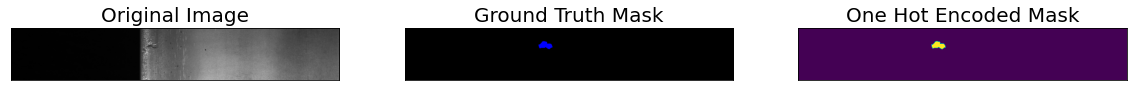

In [9]:
dataset = BuildingsDataset(x_train, y_train, class_rgb_values = select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

#### Definición de Augmentations

In [10]:
def get_training_augmentation():
    train_transform = [    
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height = 1632, min_width = 1632, always_apply = True, border_mode = 0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualización de imagen augmented y su mask

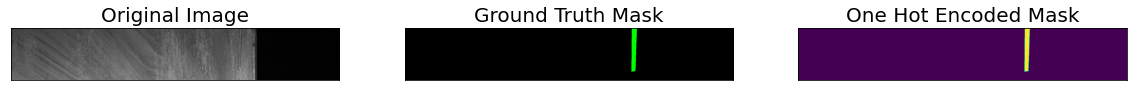

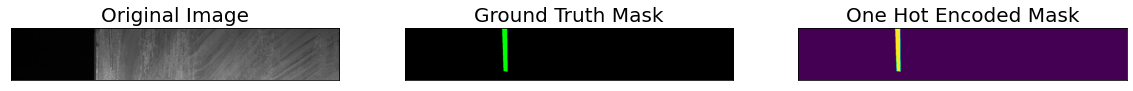

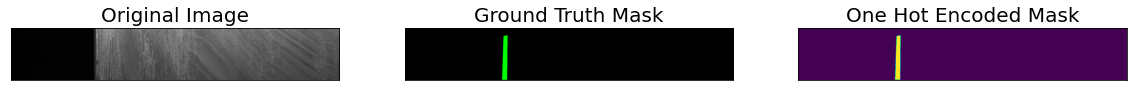

In [11]:
augmented_dataset = BuildingsDataset(x_train, y_train, augmentation = get_training_augmentation(),
                                                       class_rgb_values = select_class_rgb_values)

random_idx = random.randint(0, len(augmented_dataset)-1)

for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

#### Entrenamiento DeepLabV3+ con Pretrained ResNet101 Encoder preentrenado

#### Definición del modelo

In [12]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'softmax2d' # 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Train / Validación DataLoaders

In [13]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(x_train, y_train, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values = select_class_rgb_values)

valid_dataset = BuildingsDataset(x_valid, y_valid, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=select_class_rgb_values)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)

#### Hiperparámetros

In [14]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 4

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#### Entrenamiento de DeepLabV3+

In [16]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 225/225 [07:52<00:00,  2.10s/it, dice_loss - 0.7532, iou_score - 0.1413]
Model saved!

Epoch: 1
valid: 100%|██████████| 225/225 [06:22<00:00,  1.70s/it, dice_loss - 0.7455, iou_score - 0.146]
Model saved!

Epoch: 2
valid: 100%|██████████| 225/225 [06:23<00:00,  1.71s/it, dice_loss - 0.7459, iou_score - 0.1456]

Epoch: 3
valid: 100%|██████████| 225/225 [06:23<00:00,  1.71s/it, dice_loss - 0.7458, iou_score - 0.1457]
CPU times: user 1h 5min 12s, sys: 40min 31s, total: 1h 45min 44s
Wall time: 1h 52min 47s


#### Predicción sobre el set de test

In [17]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    best_model = torch.load('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


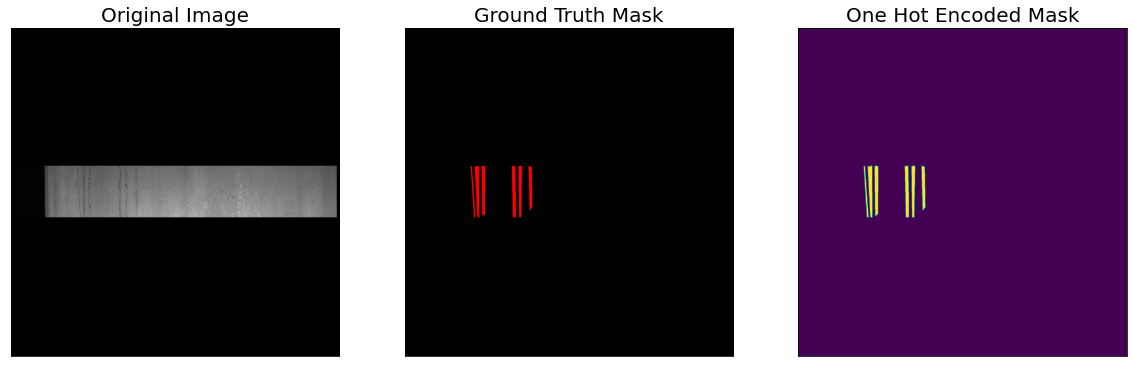

In [18]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(x_test, y_test, augmentation=get_validation_augmentation(), 
                                                preprocessing=get_preprocessing(preprocessing_fn),
                                                class_rgb_values=select_class_rgb_values)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(x_test, y_test, augmentation=get_validation_augmentation(),
                                                    class_rgb_values=select_class_rgb_values)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [22]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
#def crop_image(image, target_image_dims = [256, 1600, 3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [23]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

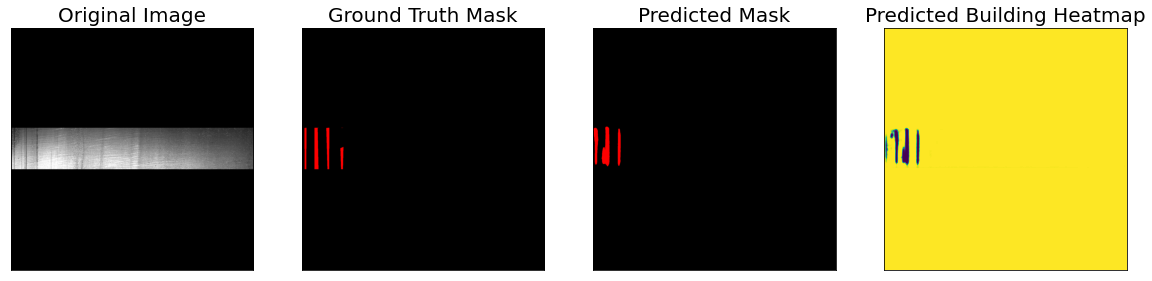

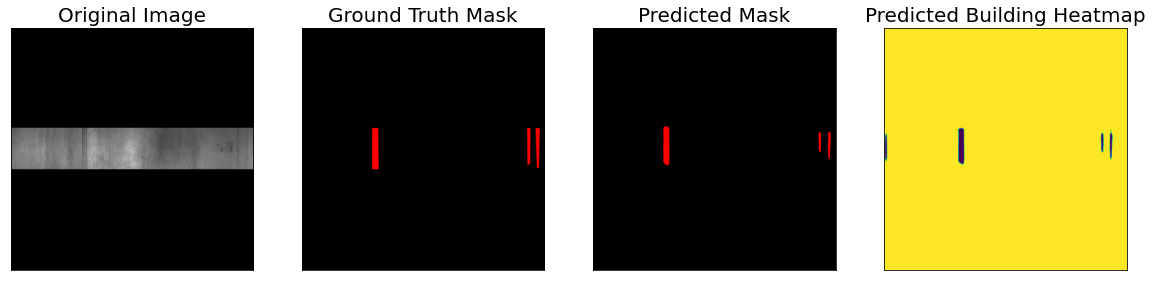

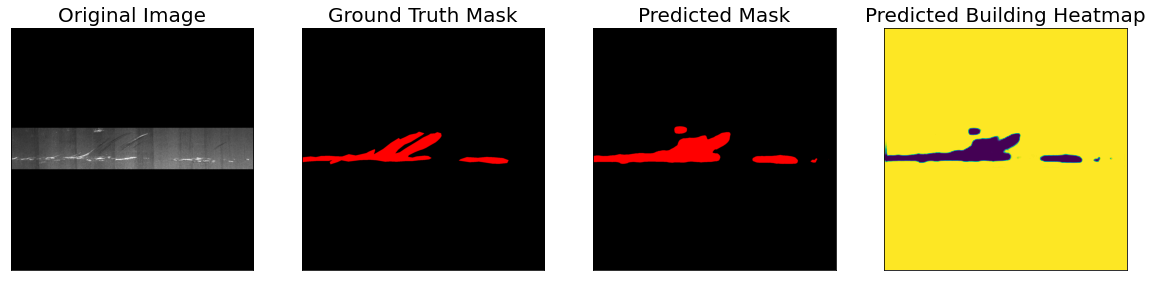

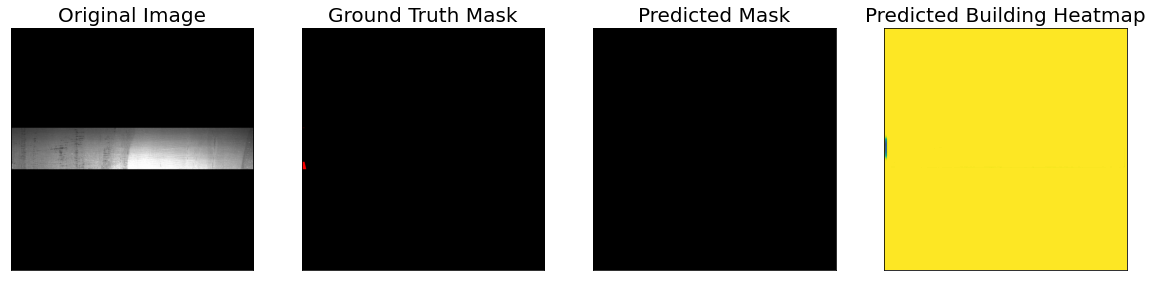

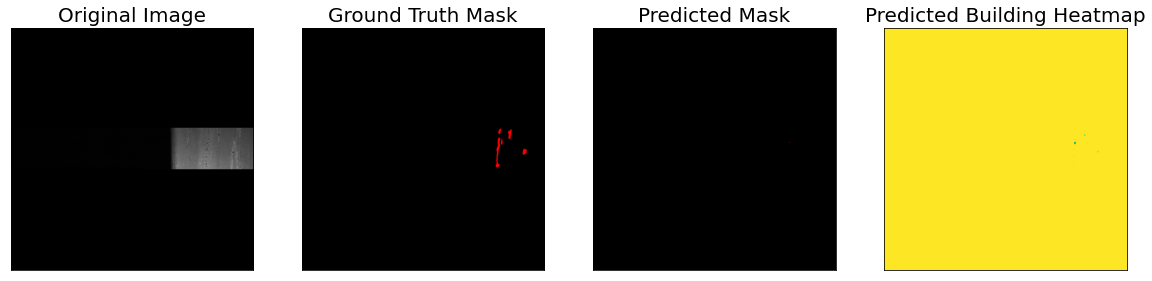

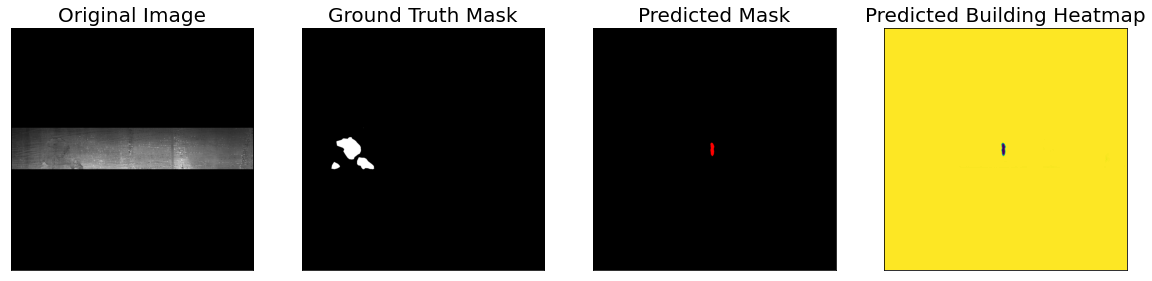

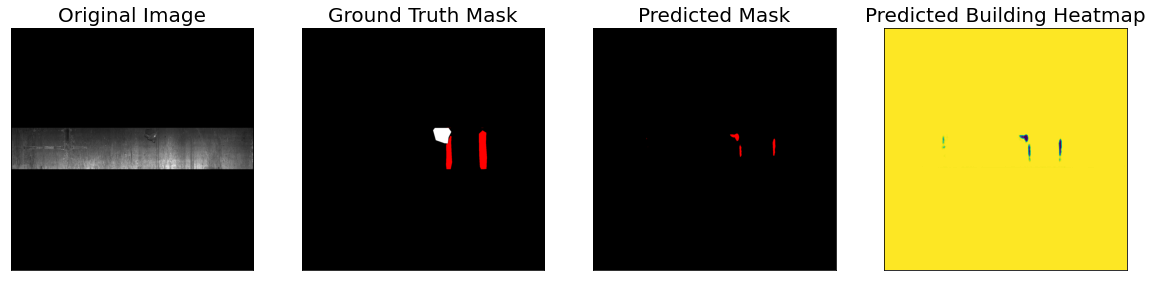

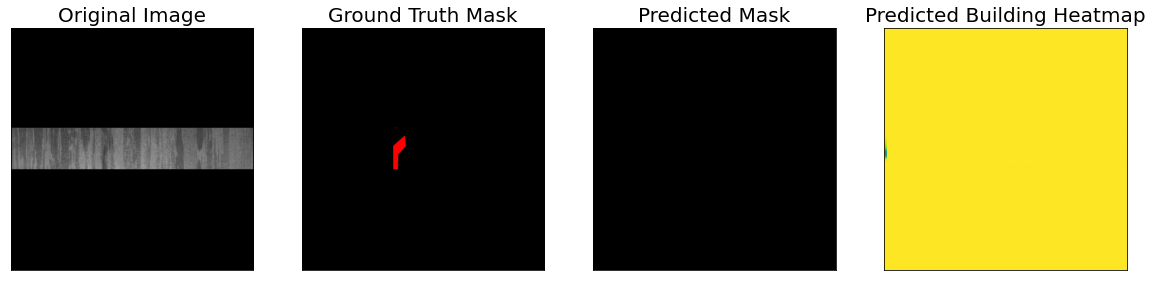

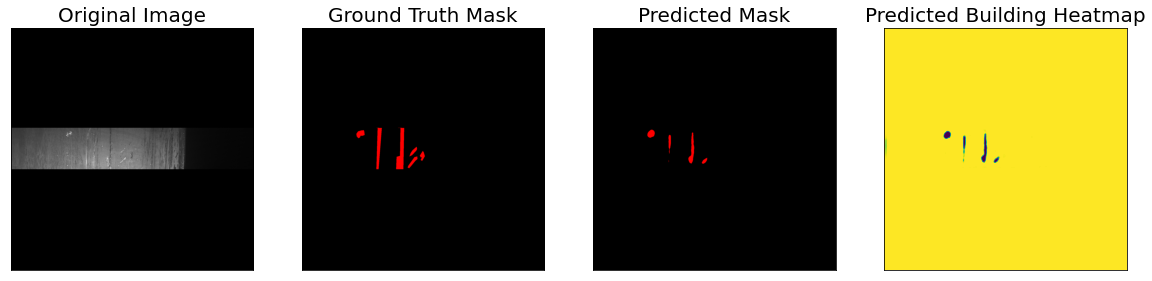

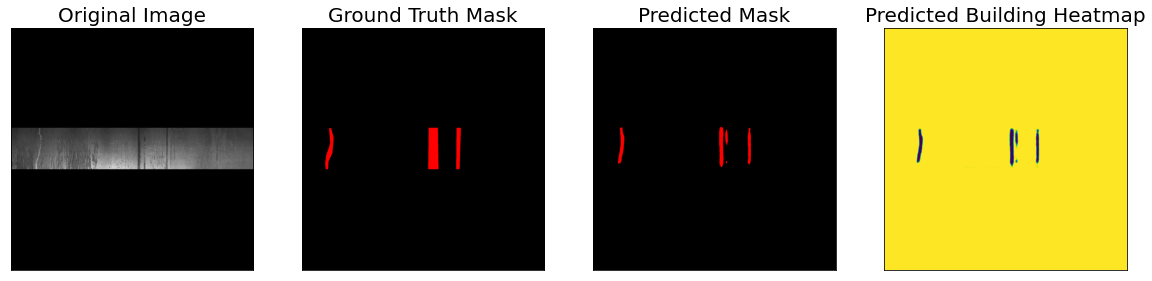

In [24]:
#for idx in range(len(test_dataset)):
for idx in range(10):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('1')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

#### Evaluación sobre el set de test

In [25]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 900/900 [14:16<00:00,  1.05it/s, dice_loss - 0.7449, iou_score - 0.1463]
Evaluation on Test Data: 
Mean IoU Score: 0.1463
Mean Dice Loss: 0.7449


#### Plot de la Dice Loss y la métrica IoU (Train vs Valid)

In [26]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3
dice_loss,0.097190,0.043254,0.040144,0.039098
iou_score,0.877547,0.921022,0.925380,0.926809


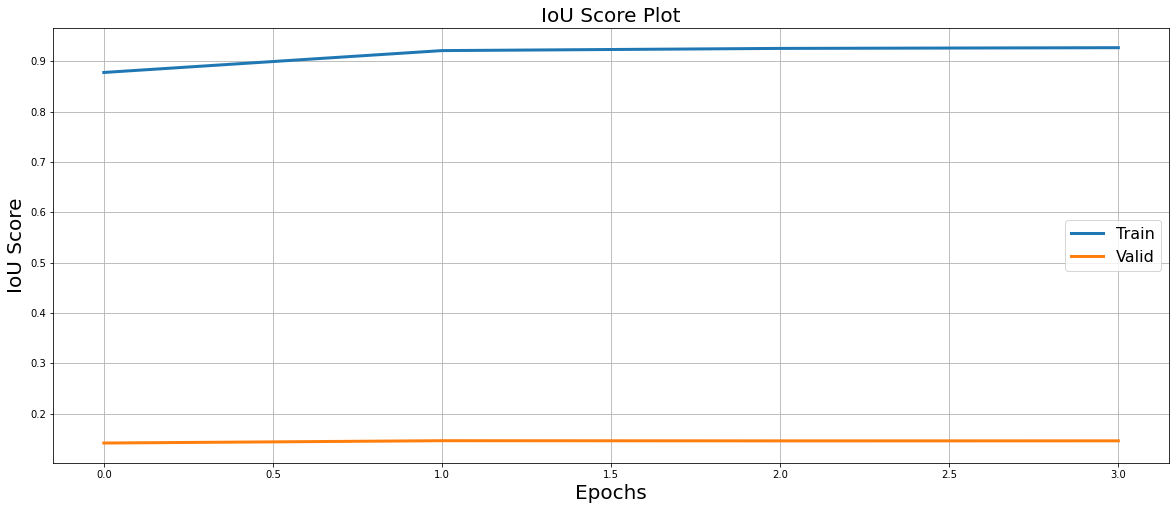

In [27]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

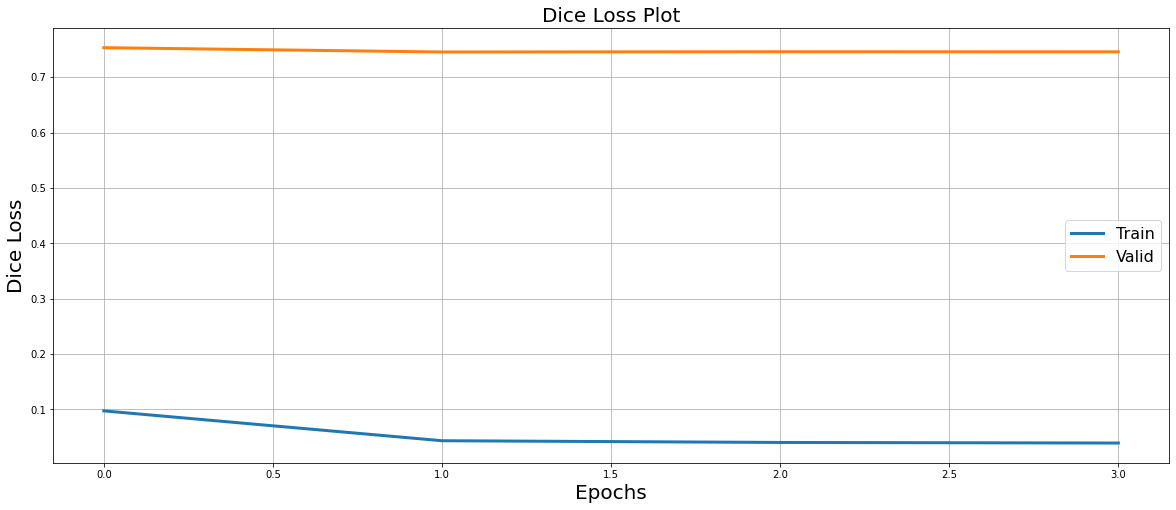

In [28]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

### Resumen


Se entrenó la red DeepLabV3+ con el dataset Severstal Steel Defect.

Se adaptó el script presentado en la cursada (cantidad de clases, softmax2d, etc). Se implementró para el entrenamiento la técnica de Data Augmentation.

El modelo fue entrenado solo por 4 epochs (recursos computacionales limitados), por tal motivo es que las métricas no fueron muy buenas. Sin embargo, la predicción sobre el test no resultó tan mala. Con más entrenamiento se conseguiría un mejor desempeño del modelo.

